In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

def feature_engineering(df):

    df_eng = df.copy()

    df_eng = df_eng.drop(columns=['Id', 'AvgTime'])

    df_eng['VIP'] = df_eng['VIP'].fillna(False).astype(int)
    df_eng['Age'] = df_eng['Age'].fillna(df_eng['Age'].median())
    df_eng[['Food', 'Drinks']] = df_eng[['Food', 'Drinks']].fillna(0)

    df_eng['TotalSpent'] = df_eng['Food'] + df_eng['Drinks']
    df_eng['Has_Spent'] = (df_eng['TotalSpent'] > 0).astype(int)
    df_eng['FoodShare'] = df_eng['Food'] / (df_eng['TotalSpent'] + 0.01)
    
    # --- Vinyl: imputación por PreferedAlbum ---
    # 1) Calcula la moda de Vinyl por álbum usando solo los NO-NaN
    vinyl_mode_by_album = (
        df_eng.dropna(subset=['Vinyl'])
            .groupby('PreferedAlbum')['Vinyl']
            .agg(lambda x: x.mode().iloc[0])
    )

    # 2) Rellena los NaN de Vinyl con la moda del álbum correspondiente
    mask = df_eng['Vinyl'].isna()
    df_eng.loc[mask, 'Vinyl'] = df_eng.loc[mask, 'PreferedAlbum'].map(vinyl_mode_by_album)

    # 3) Si aún quedan NaN (álbum no visto o sin moda), rellena con la moda global
    global_mode_vinyl = df_eng['Vinyl'].mode(dropna=True)[0]
    df_eng['Vinyl'] = df_eng['Vinyl'].fillna(global_mode_vinyl).astype(int)

    modePreferedAlbum = df_eng['PreferedAlbum'].mode()[0]
    df_eng['PreferedAlbum'] = df_eng['PreferedAlbum'].fillna(modePreferedAlbum)
    
    modeConcert = df_eng['Concert'].mode()[0]
    df_eng['Concert'] = df_eng['Concert'].fillna(modeConcert)

    #Tickets
    # Tickets
    ticket = (
        df_eng['TicketInfo']
        .fillna('Unknown/Unknown/Unknown')
        .str.split('/', expand=True)
    )

    df_eng['Ticket_Zone'] = ticket[0]
    df_eng['Ticket_Number'] = pd.to_numeric(ticket[1], errors='coerce')
    df_eng['Ticket_Type'] = ticket[2]
    # Ticket_Number: crea flag + imputa
    df_eng['Ticket_Number_Missing'] = df_eng['Ticket_Number'].isna().astype(int)
    df_eng['Ticket_Number'] = df_eng['Ticket_Number'].fillna(df_eng['Ticket_Number'].median())
    df_eng = df_eng.drop(columns=['TicketInfo'])

    scale_cols = ['Age', 'Food', 'Drinks', 'TotalSpent', 'Ticket_Number']

    for col in scale_cols:
        mean = df_eng[col].mean()
        std = df_eng[col].std()
        df_eng[col] = (df_eng[col] - mean) / std


    return df_eng

train_df = feature_engineering(train)
test_df = feature_engineering(test)

C:\Users\Admin\AppData\Local\Temp\ipykernel_22424\806540683.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eng['VIP'] = df_eng['VIP'].fillna(False).astype(int)
C:\Users\Admin\AppData\Local\Temp\ipykernel_22424\806540683.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eng['Vinyl'] = df_eng['Vinyl'].fillna(global_mode_vinyl).astype(int)
C:\Users\Admin\AppData\Local\Temp\ipykernel_22424\806540683.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.in

In [4]:
train_df.info()
y = train_df['FreePass']
train_df = train_df.drop(columns=['FreePass'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10116 entries, 0 to 10115
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PreferedAlbum          10116 non-null  object 
 1   Vinyl                  10116 non-null  int64  
 2   Opinion                8613 non-null   object 
 3   Concert                10116 non-null  object 
 4   Age                    10116 non-null  float64
 5   VIP                    10116 non-null  int64  
 6   Food                   10116 non-null  float64
 7   Drinks                 10116 non-null  float64
 8   FreePass               10116 non-null  bool   
 9   TotalSpent             10116 non-null  float64
 10  Has_Spent              10116 non-null  int64  
 11  FoodShare              10116 non-null  float64
 12  Ticket_Zone            10116 non-null  object 
 13  Ticket_Number          10116 non-null  float64
 14  Ticket_Type            10116 non-null  object 
 15  Ti

In [5]:
num_cols = ['Age', 'Food', 'Drinks', 'TotalSpent', 'Ticket_Number', 'FoodShare']
bool_cols = ['VIP', 'Has_Spent', 'Vinyl']
cat_cols = ['PreferedAlbum', 'Concert', 'Ticket_Zone', 'Ticket_Type']

for df in [train_df, test_df]:
    df['Opinion'] = (
        df['Opinion']
        .fillna('')
        .astype(str)
        .str.lower()
        .str.replace(r'[^a-z0-9\s]', ' ', regex=True)
        .str.replace(r'\s+', ' ', regex=True)
        .str.strip()
    )


In [6]:
text_train = train_df['Opinion']
text_test  = test_df['Opinion']

train_df_no_text = train_df.drop(columns=['Opinion'])
test_df_no_text  = test_df.drop(columns=['Opinion'])

train_X = pd.get_dummies(train_df_no_text, columns=cat_cols, dummy_na=True)
test_X  = pd.get_dummies(test_df_no_text,  columns=cat_cols, dummy_na=True)

train_X, test_X = train_X.align(test_X, join='left', axis=1, fill_value=0)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# vectorizer = TfidfVectorizer(
#     min_df=2,
#     max_df=0.9,
#     ngram_range=(1,2),
#     max_features=30000
# )

vectorizer = CountVectorizer(
    min_df=2,
    stop_words='english',
    strip_accents='unicode'
)

Xtr_text = vectorizer.fit_transform(text_train)
Xte_text = vectorizer.transform(text_test)

In [ ]:
train_X_notxt = train_X.drop(columns=['Opinion'], errors='ignore')
test_X_notxt  = test_X.drop(columns=['Opinion'], errors='ignore')

In [9]:
from scipy.sparse import hstack, csr_matrix

Xtr_other = csr_matrix(train_X_notxt.to_numpy(dtype=float))
Xte_other = csr_matrix(test_X_notxt.to_numpy(dtype=float))


Xtr_final = hstack([Xtr_other, Xtr_text])
Xte_final = hstack([Xte_other, Xte_text])


In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

drop_cols = ['PreferedAlbum_nan', 'Concert_nan', 'Ticket_Zone_RT', 'Ticket_Zone_nan', 'Ticket_Type_nan']
train_X_notxt = train_X_notxt.drop(columns=drop_cols, errors='ignore')
test_X_notxt  = test_X_notxt.drop(columns=drop_cols, errors='ignore')

eliminate_cols = ['Ticket_Zone_PB', 'Ticket_Zone_Unknown', 'Ticket_Number_Missing',
                  'Ticket_Type_Unknown', 'Ticket_Zone_A', 'Concert_SF14-7pm', 'Concert_FL16-7pm']
train_X_notxt = train_X_notxt.drop(columns=eliminate_cols, errors='ignore')
test_X_notxt  = test_X_notxt.drop(columns=eliminate_cols, errors='ignore')

train_X_notxt['HighFoodShare'] = (train_X_notxt['FoodShare'] > 0.7).astype(int)
test_X_notxt['HighFoodShare'] = (test_X_notxt['FoodShare'] > 0.7).astype(int)

X_train_notxt, X_val_notxt, y_train, y_val = train_test_split(
    train_X_notxt,
    y,
    test_size=0.30,
    random_state=42,
)

X_train, X_val, y_train, y_val = train_test_split(
    Xtr_final,
    y,
    test_size=0.30,
    random_state=42,
)   

from sklearn.linear_model import LogisticRegression

clfLog = LogisticRegression(
    max_iter=3000,
    C=2,
    solver='liblinear',
)

clfSLV = LinearSVC(
    max_iter=3000,
    C=1,
)

# clfRFold = RandomForestClassifier(
#     n_estimators=500,
#     max_depth=10,
#     random_state=42,
#     class_weight='balanced'
# )

# Best params: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 5, 
#               'max_features': 0.3, 'max_depth': 8, 'class_weight': None, 'bootstrap': True}

clfRF = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=2,
    min_samples_leaf=5,
    max_features=0.3,
    max_depth=8,
    random_state=42,
    class_weight=None,
    bootstrap=True
)
# Best params: {'n_estimators': 800, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 0.3, 
#               'max_depth': 12, 'class_weight': None, 'bootstrap': True}

clfDT = DecisionTreeClassifier(
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)


clfLog.fit(X_train, y_train)
clfSLV.fit(X_train, y_train)
clfRF.fit(X_train_notxt, y_train)
clfDT.fit(X_train, y_train)


from sklearn.metrics import accuracy_score, classification_report

y_pred_Log = clfLog.predict(X_val)
y_pred_SLV = clfSLV.predict(X_val)
y_pred_RF  = clfRF.predict(X_val_notxt)
y_pred_DT  = clfDT.predict(X_val)

print("Accuracy Log (YES Opinion):", accuracy_score(y_val, y_pred_Log))
# print(classification_report(y_val, y_pred_Log))

print("Accuracy SLV (YES Opinion):", accuracy_score(y_val, y_pred_SLV))
# print(classification_report(y_val, y_pred_SLV))

print("Accuracy RF (NO Opinion):", accuracy_score(y_val, y_pred_RF))
# print(classification_report(y_val, y_pred_RF))

print("Accuracy DT (YES Opinion):", accuracy_score(y_val, y_pred_DT))
# print(classification_report(y_val, y_pred_DT))


Accuracy Log (YES Opinion): 0.8079077429983526
Accuracy SLV (YES Opinion): 0.8065897858319605
Accuracy RF (NO Opinion): 0.8184514003294893
Accuracy DT (YES Opinion): 0.8092257001647446


In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


X_train_notxt, X_val_notxt, y_train, y_val = train_test_split(
    train_X_notxt,
    y,
    test_size=0.30,
    random_state=42,
)

clfRF = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# Define the parameters to try during Randomized Search
param_dist = {
    "n_estimators": [300, 500, 800, 1200],
    "max_depth": [None, 8, 12, 16, 20],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "min_samples_split": [2, 5, 10, 20],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
    "bootstrap": [True],                 # RF típico
    "class_weight": [None, "balanced"]   # a veces ayuda
}

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Divides the data into 5 folds, preserving class distribution, shuffling for randomness.
# Folding means that in each iteration, 4 folds are used for training and 1 for validation.


# It checks 50 different combinations of the above parameters
# The Kfold divides the data into 5 parts, training on 4 and validating on 1 each time. 
# For each combination of parameters it finds 5 values of the accuracy and then averages them to get a final score.
search = RandomizedSearchCV(
    estimator=clfRF,
    param_distributions=param_dist,
    n_iter=50, # number of different combinations to try
    scoring='accuracy',
    cv = CV,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_notxt, y_train)

print("Best CV accuracy:", search.best_score_)
print("Best params:", search.best_params_)
best_rf = search.best_estimator_

results = pd.DataFrame(search.cv_results_)
cols = ["mean_test_score", "std_test_score", "rank_test_score", "params"]
results[cols].sort_values("rank_test_score").head(10)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV accuracy: 0.819941170372674
Best params: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.3, 'max_depth': 8, 'class_weight': None, 'bootstrap': True}


,mean_test_score,std_test_score,rank_test_score,params
18,0.819941,0.005808,1,"{'n_estimators': 800, 'min_samples_split': 2, ..."
41,0.819094,0.008101,2,"{'n_estimators': 800, 'min_samples_split': 20,..."
20,0.818811,0.010490,3,"{'n_estimators': 500, 'min_samples_split': 10,..."
2,0.818529,0.006642,4,"{'n_estimators': 1200, 'min_samples_split': 20..."
7,0.818388,0.008483,5,"{'n_estimators': 1200, 'min_samples_split': 2,..."
8,0.817964,0.009807,6,"{'n_estimators': 300, 'min_samples_split': 5, ..."
40,0.817964,0.007068,7,"{'n_estimators': 300, 'min_samples_split': 5, ..."
25,0.817823,0.007776,8,"{'n_estimators': 500, 'min_samples_split': 20,..."
48,0.817682,0.009993,9,"{'n_estimators': 500, 'min_samples_split': 20,..."
10,0.817258,0.007063,10,"{'n_estimators': 500, 'min_samples_split': 2, ..."


In [90]:
import pandas as pd

best_rf = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=20,
    min_samples_leaf=5,
    max_features=0.3,
    max_depth=12,
    random_state=42,
    class_weight=None,
    bootstrap=True
)

best_rf.fit(X_train_notxt, y_train)

importances = pd.Series(
    best_rf.feature_importances_,
    index=X_train_notxt.columns
).sort_values(ascending=False)

importances.head(100)

TotalSpent                        0.183197
Has_Spent                         0.141826
FoodShare                         0.120042
Vinyl                             0.106615
Food                              0.086142
Drinks                            0.081159
Ticket_Number                     0.069576
Age                               0.038464
HighFoodShare                     0.032967
PreferedAlbum_Kind of Blue        0.028871
PreferedAlbum_Head Hunters        0.021070
PreferedAlbum_Bright Size Life    0.016544
Ticket_Zone_CB                    0.014956
Ticket_Zone_B                     0.012156
Ticket_Type_XL                    0.011854
Ticket_Type_N                     0.010679
Ticket_Zone_LB                    0.008987
Concert_NYC12-5pm                 0.008630
Ticket_Zone_LT                    0.005219
Ticket_Zone_RB                    0.000641
VIP                               0.000404
dtype: float64

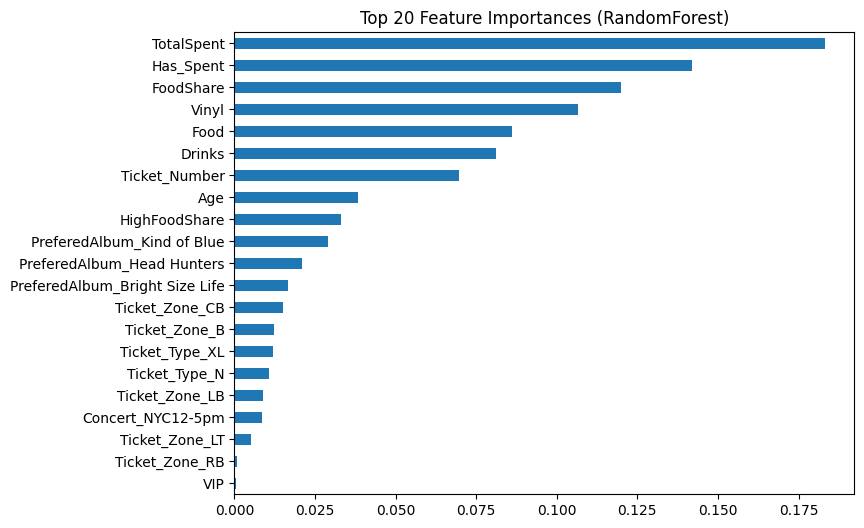

In [91]:
import matplotlib.pyplot as plt

importances.head(100).plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (RandomForest)")
plt.show()


In [80]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_rf,
    X_val_notxt,      # usa validación, no train
    y_val,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

perm_importances = pd.Series(
    perm.importances_mean,
    index=X_val_notxt.columns
).sort_values(ascending=False)



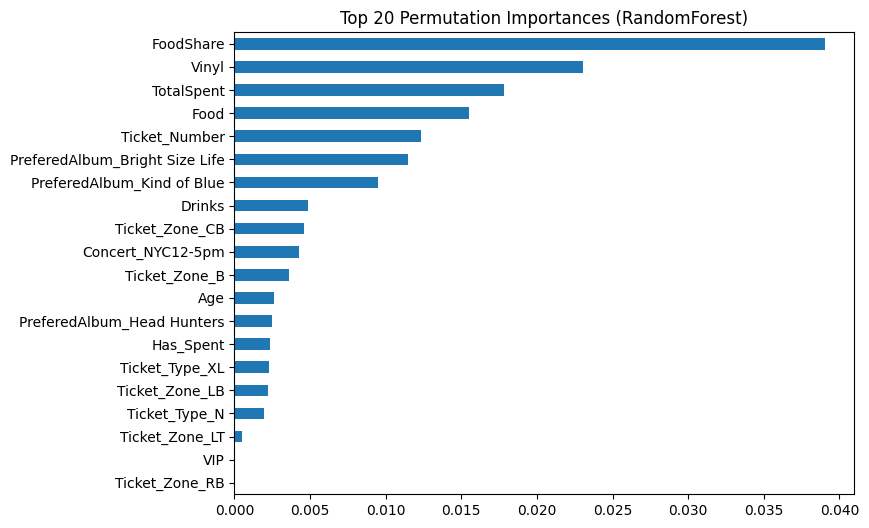

In [81]:
perm_importances.head(100).plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top 20 Permutation Importances (RandomForest)")
plt.show()

c:\Users\Admin\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


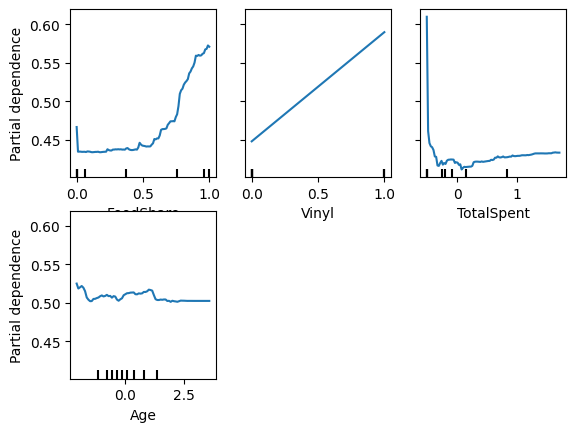

In [82]:
from sklearn.inspection import PartialDependenceDisplay

features = ['FoodShare', 'Vinyl', 'TotalSpent', 'Age']
PartialDependenceDisplay.from_estimator(
    best_rf, X_val_notxt, features
)


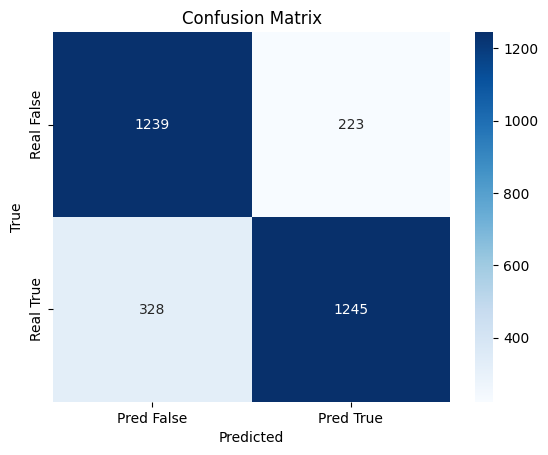

In [93]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred_RF)
cm
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred False", "Pred True"],
    yticklabels=["Real False", "Real True"]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [96]:
errors = X_val_notxt.copy()
errors['y_true'] = y_val
errors['y_pred'] = best_rf.predict(X_val_notxt)

errors['error_type'] = 'Correct'
errors.loc[(errors.y_true == 0) & (errors.y_pred == 1), 'error_type'] = 'False Positive'
errors.loc[(errors.y_true == 1) & (errors.y_pred == 0), 'error_type'] = 'False Negative'

fp = errors[errors.error_type == 'False Positive']
fn = errors[errors.error_type == 'False Negative']
correct = errors[errors.error_type == 'Correct']

In [98]:
cols = ['FoodShare', 'TotalSpent', 'Ticket_Number', 'Age']

errors.groupby('error_type')[cols].mean()

,FoodShare,TotalSpent,Ticket_Number,Age
error_type,,,,
Correct,0.319853,0.026100,-0.032624,0.006174
False Negative,0.724626,0.018274,0.012358,0.078276
False Positive,0.335605,-0.226774,0.187160,-0.226648


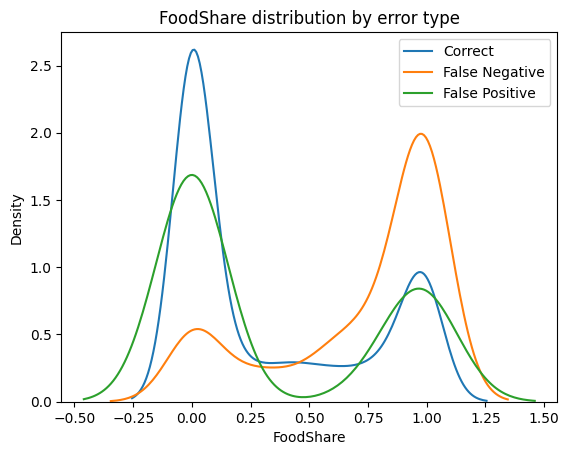

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(correct['FoodShare'], label='Correct')
sns.kdeplot(fn['FoodShare'], label='False Negative')
sns.kdeplot(fp['FoodShare'], label='False Positive')
plt.legend()
plt.title('FoodShare distribution by error type')
plt.show()


In [41]:
clfRF.fit(train_X_notxt, y)
y_test_pred = clfRF.predict(test_X_notxt)
submission = pd.DataFrame({
    'Id': test['Id'],
    'FreePass': y_test_pred
})
submission.to_csv('submission.csv', index=False)